# The History of Semantic Spaces

Google's [Ngram viewer](https://books.google.com/ngrams/) is awesome. Among other things, it's useful for studying historical interest in particular ideas. The [2011 _Science_ paper](http://www.sciencemag.org/content/331/6014/176.full.pdf) has some fascinating examples of this. Here's one of the _least_ impressive examples from that paper:

![ngram example](figures/ngram_example1.png)

The problem with this approach is that it's impossible to tell the difference between intrest in the _idea_ of God and usage of the _word_ "God". This is elegantly demonstrated with another example from that paper:

![ngram example](figures/ngram_example2.png)

If we had searched only for "the Great War", we might have thought that interest in that topic waned after the start of World War II. The truth, though, is that people became _more_ interested in the Great War. They just started calling it "World War I" instead.

The _Science_ paper shows off some elegant solutions to this problem, but all are both extremely labor-intensive and applicable only to the question they were designed to answer. Wouldn't it be nice to have an automated way to search for _semantic spaces_ rather than having to guess at the particular Ngrams that represent them?

I think I can make that happen.
## The Plan
My plan is to leverage cutting-edge semantic embeddings to generate a list of closely related words from a search term. Then I'll get timeseries data from the Ngram viewer for each of those words. Finally, I'll aggredate the data across words in the set, weighting them by their semantic similarity to the search term. This weighted sum will thus give an account of historical interest in the whole semantic space surrounding the search term.

## Step 1: Defining Semantic Spaces
The first step is to get a list of closely related words, along with a quantification of their semantic similarity to the target. This is made trivial by the `gensim` package, which comes with a number of pretrained model vector embeddings. I'll use the "glove-wiki-gigaword-200" dataset, which is trained on Wikipedia (as it was in 2014) and the Gigaword newswire archive. As such, it provide a reasonable estimate of the kind of associations I (as a literate person living around 2014) might have with any given word - with some bias toward newsworthiness.

In [5]:
import numpy as np
import pandas as pd
import gensim.downloader as gs

glove_vectors = gs.load('glove-wiki-gigaword-200')
glove_vectors.sort_by_descending_frequency()

Now we can get our list of most closely related words. For now I'm not going to worry about exactly what "closely related" means, but this will become important later.

In [167]:
glove_vectors.most_similar(['science', 'math'], topn = 10)

[('mathematics', 0.768941342830658),
 ('physics', 0.6959351301193237),
 ('biology', 0.6668677926063538),
 ('teaching', 0.6357982158660889),
 ('curriculum', 0.635124921798706),
 ('chemistry', 0.6340017318725586),
 ('sciences', 0.6332299709320068),
 ('education', 0.6304562091827393),
 ('graduate', 0.626822829246521),
 ('academic', 0.6119447350502014)]

## Step 2: Scraping
The next prerequisite is the ability to get ngram data with code. The code below does this, outputing a nicely formated pandas DataFrame with a column for each ngram.

In [6]:
import requests

def get_ngrams(query, start_year = 1800, end_year = 2019):
    # Define Parameters for Request
    params = {
    "content": query,
    "year_start": start_year,
    "year_end": end_year
    }
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.87 Safari/537.36",
    }
    # Make Request
    html = requests.get("https://books.google.com/ngrams/json", params=params, headers=headers, timeout=30).text
    
    # Clean Data
    df = pd.read_json(html)
    df = pd.DataFrame(df['timeseries'].tolist(), columns = np.arange(params['year_start'], params['year_end']+1), index = df['ngram'])
    df.index.name = "year"
    df = df.transpose()
    return df

In [10]:
df = get_ngrams("the Great War, World War I, World War II")
df.head()

year,the Great War,World War I,World War II
1800,8.974027e-09,8.142913e-08,1.477712e-07
1801,7.179222e-09,6.514330e-08,1.182169e-07
1802,5.982685e-09,5.428609e-08,9.902060e-08
1803,5.479016e-09,4.653093e-08,8.487480e-08
1804,4.345168e-09,3.009015e-08,5.482785e-08


## Step 3: Putting it Together

The class `SemanticHistory` takes as input a search term (or list of terms whose vector embeddings are to be averaged) and generates a list of similar words (100 by default) along with their cosine similarity to the input, `self.most_similar`. It feeds this list of words into the Ngram viewer, and creates a dataframe with weighted frequencies for each word in the list, `self.raw_data`. The `plot` method displays a stacked area plot.

In [242]:
import plotly.express as px

class SemanticHistory:
    def __init__(self, search = [], sample_n = 20, start_year = 1800, end_year = 2019):
        if type(search) == list:
            self.search = [str.lower(str(s)) for s in list(search)]
        else:
            self.search = [str.lower(str(search))]
        self.sample_n = sample_n

        if not any(" " in s for s in search):
            self.most_similar = glove_vectors.most_similar(self.search, topn = sample_n)
            words = self.search + [word[0] for word in self.most_similar]
            similarities = [1]*len(self.search) + [word[1] for word in self.most_similar]
            query = ', '.join(words)
            self.raw_data = get_ngrams(query, start_year, end_year)
            self.data = self.raw_data.multiply(similarities).sum(axis = 1)
        else:
            raise Exception("Input must be a single word or list of single words.")
    def plot(self):
        fig = px.area(self.raw_data.iloc[:, :10],
                      labels = {'value':'Weighted Frequency', 'year':'Word', 'index':'Year'},
                      template = 'plotly_white')
        fig.update_layout(legend=dict(title=None))
        fig.show()

In [243]:
food_history = SemanticHistory(search = "Food")

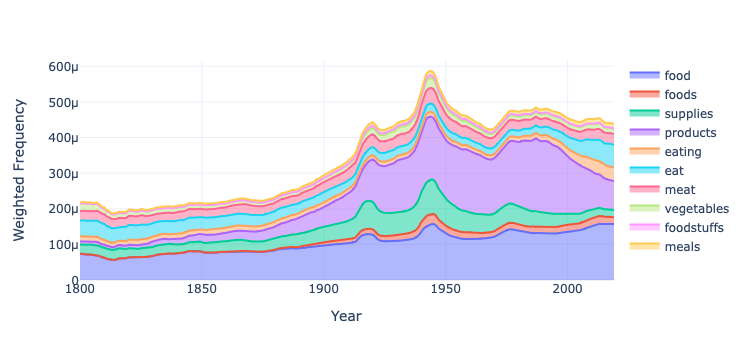

In [245]:
food_history.plot()